In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflixpreprocesseddata/Netflix_preprocessed_data_updated.csv
/kaggle/input/bt5153-applied-machine-learning-spring-2023/sample_submission.csv
/kaggle/input/bt5153-applied-machine-learning-spring-2023/train.csv
/kaggle/input/bt5153-applied-machine-learning-spring-2023/test.csv


In [ ]:
## Reading pre-processed data
df1 = pd.read_csv("/kaggle/input/netflixpreprocesseddata/Netflix_preprocessed_data_updated.csv")
df1.head()

,Unnamed: 0,series_movie,Director,Writer,Actors,View_rating,IMDb_score,Awards_received,Awards_nominated_for,Boxoffice,...,Genre_History,Genre_Biography,Genre_Crime,Genre_Reality-tv,Genre_Family,Genre_Short,Genre_Drama,Genre_Comedy,Genre_Sci-fi,Genre_Game-show
0,0,1,5933,4181,6661,15,7.9,74,57,2122065.0,...,0,0,1,0,0,0,1,0,0,0
1,1,0,1049,1221,8994,15,5.8,1,0,70632.0,...,0,0,0,0,0,0,0,1,0,0
2,2,0,732,1097,3876,24,4.3,0,0,16263.0,...,0,0,0,0,0,0,1,0,0,0
3,3,1,6400,9355,11730,26,6.5,1,0,NaN,...,0,0,0,0,0,0,1,0,0,0
4,4,0,5561,9355,9424,26,6.3,0,4,NaN,...,0,0,0,0,0,1,1,0,0,0


In [ ]:
df1.columns

Index(['Unnamed: 0', 'series_movie', 'Director', 'Writer', 'Actors',
       'View_rating', 'IMDb_score', 'Awards_received', 'Awards_nominated_for',
       'Boxoffice',
       ...
       'Genre_History', 'Genre_Biography', 'Genre_Crime', 'Genre_Reality-tv',
       'Genre_Family', 'Genre_Short', 'Genre_Drama', 'Genre_Comedy',
       'Genre_Sci-fi', 'Genre_Game-show'],
      dtype='object', length=2092)

In [ ]:
## Dropping columns
df_updated = df1.drop(['Boxoffice','Summary','IMDb_votes','IMDb_score',"Unnamed: 0"], axis = 1)
df_updated.head()

,series_movie,Director,Writer,Actors,View_rating,Awards_received,Awards_nominated_for,poster_1,poster_2,poster_3,...,Genre_History,Genre_Biography,Genre_Crime,Genre_Reality-tv,Genre_Family,Genre_Short,Genre_Drama,Genre_Comedy,Genre_Sci-fi,Genre_Game-show
0,1,5933,4181,6661,15,74,57,1.144354,1.087981,1.504703,...,0,0,1,0,0,0,1,0,0,0
1,0,1049,1221,8994,15,1,0,0.068309,0.379032,0.342400,...,0,0,0,0,0,0,0,1,0,0
2,0,732,1097,3876,24,0,0,0.429673,1.737647,0.558581,...,0,0,0,0,0,0,1,0,0,0
3,1,6400,9355,11730,26,1,0,0.939423,0.352481,1.118735,...,0,0,0,0,0,0,1,0,0,0
4,0,5561,9355,9424,26,0,4,0.234674,0.336971,0.216579,...,0,0,0,0,0,1,1,0,0,0


# IMDb Votes Prediction (Popularity)

In [ ]:
## Dropping IMDb score column while doing prediction for IMDb votes
df_updated_votes = df_updated.drop('IMDb_score_target1', axis = 1)
df_updated_votes.shape

(13298, 2086)

In [ ]:
# Python libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score,classification_report, ConfusionMatrixDisplay
import xgboost as xgb
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

## Train-Test Split and Data Scalling

In [ ]:
## IMDb Votes (Image and structured features)
y2 = df_updated_votes.IMDb_votes_target2
x = df_updated_votes.drop('IMDb_votes_target2', axis = 1)

x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size=0.2, random_state=22)

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)
x_std = scaler.transform(x)

## Model Building and Evaluation

In [ ]:
## Multiple models for IMDb votes prediction
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier


classifiers = {
    "BernoulliNB": BernoulliNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier(),
}


for name, sklearn_classifier in classifiers.items():
    clf1 = sklearn_classifier
    clf1.fit(x_train_std, y2_train)
    y2_pred = clf1.predict(x_test_std)
    print(y2_pred)
    acc = accuracy_score(y2_test, y2_pred)
    clf_report = pd.DataFrame(classification_report(y2_test, y2_pred, output_dict=True))
    print(name)
    print("Accuracy on Test data:", acc)
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

[0 0 1 ... 0 1 1]
BernoulliNB
Accuracy on Test data: 0.4781954887218045
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.527273    0.497938    0.381429  0.478195     0.468880   
recall       0.602076    0.542088    0.296009  0.478195     0.480058   
f1-score     0.562197    0.519076    0.333333  0.478195     0.471535   
support    867.000000  891.000000  902.000000  0.478195  2660.000000   

           weighted avg  
precision      0.467991  
recall         0.478195  
f1-score       0.470146  
support     2660.000000  
[0 1 0 ... 2 1 1]
KNeighborsClassifier
Accuracy on Test data: 0.3894736842105263
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.396154    0.410072    0.347759  0.389474     0.384662   
recall       0.475202    0.447811    0.249446  0.389474     0.390820   
f1-score     0.432092    0.428112    0.290510  0.389474     0.383571   
support    867.000000 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[0 2 2 ... 1 2 2]
LogisticRegression
Accuracy on Test data: 0.587218045112782
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.673077    0.636971    0.449886  0.587218     0.586645   
recall       0.686275    0.641975    0.437916  0.587218     0.588722   
f1-score     0.679612    0.639463    0.443820  0.587218     0.587632   
support    867.000000  891.000000  902.000000  0.587218  2660.000000   

           weighted avg  
precision      0.585299  
recall         0.587218  
f1-score       0.586207  
support     2660.000000  
[2 2 2 ... 1 1 0]
MLPClassifier
Accuracy on Test data: 0.5661654135338345
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.668172    0.611857    0.417045  0.566165     0.565691   
recall       0.682814    0.613917    0.406874  0.566165     0.567868   
f1-score     0.675414    0.612885    0.411897  0.566165     0.566732   
support    867.000000  

## Best Model (XGBoost) Building and Evaluation

In [ ]:
## XGBoost model tunning on IMDb votes prediction

# define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              learning_rate=0.1, 
                              max_depth=5, 
                              n_estimators=100)

# train the XGBoost model
xgb_model.fit(x_train_std, y2_train)

# evaluate the XGBoost model
y2_pred_xg = xgb_model.predict(x_test_std)
accuracy = accuracy_score(y2_test, y2_pred_xg)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.45%


Train data classification report:
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.940506     0.913594     0.917523  0.923952      0.923874   
recall        0.960534     0.948571     0.864491  0.923952      0.924532   
f1-score      0.950414     0.930754     0.890218  0.923952      0.923795   
support    3522.000000  3500.000000  3616.000000  0.923952  10638.000000   

           weighted avg  
precision      0.923839  
recall         0.923952  
f1-score       0.923484  
support    10638.000000  

Test data classification report:
CLASSIFICATION REPORT:
                    0           1           2  accuracy    macro avg  \
precision    0.812571    0.720779    0.577236  0.704511     0.703529   
recall       0.820069    0.747475    0.550998  0.704511     0.706181   
f1-score     0.816303    0.733884    0.563812  0.704511     0.704666   
support    867.000000  891.000000  902.000000  0.704511  2660.000000   

           wei

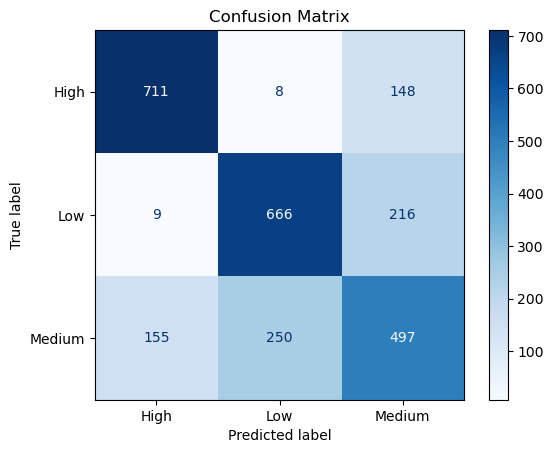

Train data metrics:
Accuracy: 0.924

Test data metrics:
Accuracy: 0.7045


In [ ]:
# Train data classification report
y2_train_pred = xgb_model.predict(x_train_std)
print("Train data classification report:")
clf_report = pd.DataFrame(classification_report(y2_train, y2_train_pred, output_dict=True))
print(f"CLASSIFICATION REPORT:\n{clf_report}")

# Test data classification report
y2_pred_xg = xgb_model.predict(x_test_std)
print("\nTest data classification report:")
clf_report = pd.DataFrame(classification_report(y2_test, y2_pred_xg, output_dict=True))
print(f"CLASSIFICATION REPORT:\n{clf_report}")

# Test data confusion matrix
cm = confusion_matrix(y2_test, y2_pred_xg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Low', 'Medium'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

print("Train data metrics:")
print(f"Accuracy: {accuracy_score(y2_train, y2_train_pred):.4}")

print("\nTest data metrics:")
print(f"Accuracy: {accuracy_score(y2_test, y2_pred_xg):.4}")

Text(0.5, 1.0, 'Relative Feature Importance for XGBoost model')

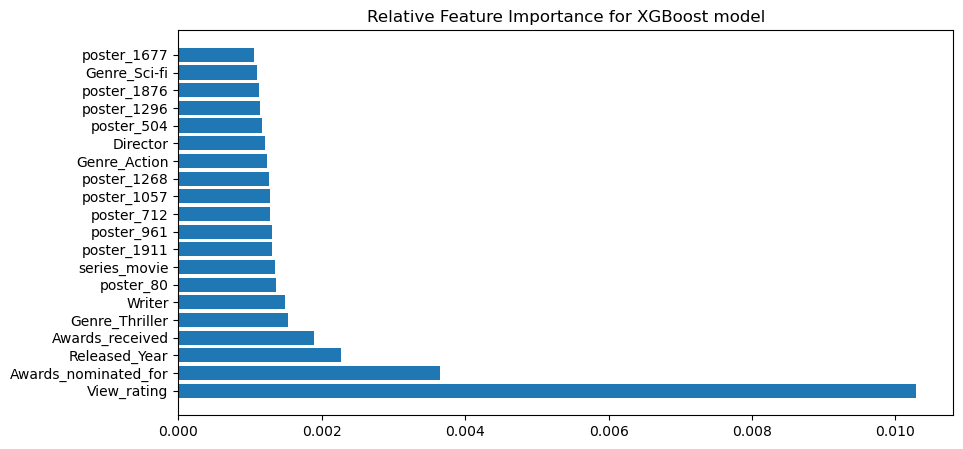

In [ ]:
#Built-in Variable Importance
plt.figure(figsize=(10,5))
num=20

XGB_importances = xgb_model.feature_importances_
order = np.flip(np.argsort(XGB_importances))[0:num]
plt.barh(range(num),
         XGB_importances[order], 
         tick_label=x_train.columns[order])
plt.title("Relative Feature Importance for XGBoost model")

## Updating dataset based on XGBoost feature importance

In [ ]:
df_updated_votes_features = df_updated_votes[['series_movie', 'View_rating', 'Awards_nominated_for', 'Awards_received', 'Writer', 'Director', 'poster_1677','Genre_Sci-fi','poster_1876', 'poster_504', 'poster_1296', 'Genre_Action','poster_1268','poster_1057', 'poster_712', 'poster_961', 'poster_1911', 'poster_80', 'Genre_Thriller','Released_Year','IMDb_votes_target2']]
df_updated_votes_features.head()

,series_movie,View_rating,Awards_nominated_for,Awards_received,Writer,Director,poster_1677,Genre_Sci-fi,poster_1876,poster_504,...,Genre_Action,poster_1268,poster_1057,poster_712,poster_961,poster_1911,poster_80,Genre_Thriller,Released_Year,IMDb_votes_target2
0,1,15,57,74,4181,5933,2.094613,0,0.158182,2.118185,...,0,0.740315,2.549453,0.645472,1.084161,1.132962,0.222275,0,2021,0
1,0,15,0,1,1221,1049,1.296326,0,1.386640,2.230821,...,0,0.104680,0.240930,2.196224,0.859131,1.937296,1.099913,0,2021,2
2,0,24,0,0,1097,732,1.376536,0,0.711059,1.074021,...,0,0.013149,0.595561,0.289381,1.159718,0.958547,1.069194,1,2021,2
3,1,26,0,1,9355,6400,0.163411,0,0.844350,0.563204,...,0,0.218615,1.215607,0.827836,0.669413,1.515545,0.232315,0,2021,2
4,0,26,4,0,9355,5561,1.682656,0,0.551851,1.115040,...,0,0.597955,0.062461,0.777684,1.348849,0.614037,0.517651,0,2021,1


In [ ]:
## Train-Test Split and Data Scalling
y2_votes = df_updated_votes_features.IMDb_votes_target2
x_votes = df_updated_votes_features.drop('IMDb_votes_target2', axis = 1)

x_train_votes, x_test_votes, y2_train_votes, y2_test_votes = train_test_split(x_votes, y2_votes, test_size=0.2, random_state=22)

scaler = StandardScaler()
x_train_std_votes = scaler.fit_transform(x_train_votes)
x_test_std_votes = scaler.transform(x_test_votes)
x_std_votes = scaler.transform(x_votes)

In [ ]:
## Multiple models for IMDb votes prediction with updated features
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier


classifiers = {
    "BernoulliNB": BernoulliNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier(),
}


for name, sklearn_classifier in classifiers.items():
    clf = sklearn_classifier
    clf.fit(x_train_std_votes, y2_train_votes)
    y2_pred_votes = clf.predict(x_test_std_votes)
    print(y2_pred_votes)
    acc = accuracy_score(y2_test_votes, y2_pred_votes)
    print(name)
    print("Accuracy on Test data:", acc)

[0 2 2 ... 1 2 0]
BernoulliNB
Accuracy on Test data: 0.6462406015037594
[0 2 2 ... 1 1 0]
KNeighborsClassifier
Accuracy on Test data: 0.5868421052631579
[0 2 2 ... 1 2 0]
LogisticRegression
Accuracy on Test data: 0.6733082706766917
[0 0 2 ... 1 2 0]
MLPClassifier
Accuracy on Test data: 0.6484962406015038
[2 2 2 ... 1 2 0]
DecisionTreeClassifier
Accuracy on Test data: 0.6037593984962406
[0 0 2 ... 1 2 0]
RandomForestClassifier
Accuracy on Test data: 0.7
[0 0 2 ... 1 2 0]
AdaBoostClassifier
Accuracy on Test data: 0.6879699248120301
[0 0 2 ... 1 2 0]
XGBClassifier
Accuracy on Test data: 0.6992481203007519


## XGBoost Model Building and hyper-parameter tunning on updated data

In [ ]:
## XGBoost model tunning on IMDb votes prediction

# define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              learning_rate=0.1, 
                              max_depth=5, 
                              n_estimators=100)

# train the XGBoost model
xgb_model.fit(x_train_std_votes, y2_train_votes)

# evaluate the XGBoost model
y2_pred_xg = xgb_model.predict(x_test_std_votes)
accuracy = accuracy_score(y2_test_votes, y2_pred_xg)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.49%


In [ ]:
# optimize the XGBoost model
parameters = {'max_depth': [3, 5, 7], 
              'learning_rate': [0.1, 0.01, 0.001]}
xgb_optimized = GridSearchCV(xgb_model, parameters, cv=3, n_jobs=-1)

xgb_optimized.fit(x_train_std_votes, y2_train_votes)
print("Optimal Parameters: ", xgb_optimized.best_params_)

# make predictions using the optimized model
y2_pred_optimized = xgb_optimized.predict(x_test_std_votes)
accuracy_optimized = accuracy_score(y2_test_votes, y2_pred_optimized)
print("Optimized Accuracy: %.2f%%" % (accuracy_optimized * 100.0))

Optimal Parameters:  {'learning_rate': 0.1, 'max_depth': 5}
Optimized Accuracy: 70.49%


# IMDb Scores Prediction (Quality)

In [ ]:
## Remove IMDb votes feature while doing prediction for IMDb scores
df_updated_score = df_updated.drop('IMDb_votes_target2', axis = 1)
df_updated_score.shape

(13298, 2086)

In [ ]:
## Train-Test Split and Data Scalling
y1 = df_updated_score.IMDb_score_target1
X = df_updated_score.drop('IMDb_score_target1', axis = 1)

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=22)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_std = scaler.transform(X)

In [ ]:
## Multiple models for IMDb scores prediction
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier


classifiers = {
    "BernoulliNB": BernoulliNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier(),
}


for name, sklearn_classifier in classifiers.items():
    clf = sklearn_classifier
    clf.fit(X_train_std, y1_train)
    y1_pred = clf.predict(X_test_std)
    print(y1_pred)
    acc = accuracy_score(y1_test, y1_pred)
    print(name)
    print("Accuracy:", acc)

[2 2 2 ... 0 1 2]
BernoulliNB
Accuracy: 0.42255639097744363
[1 0 2 ... 0 0 2]
KNeighborsClassifier
Accuracy: 0.37593984962406013


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[2 1 2 ... 1 0 0]
LogisticRegression
Accuracy: 0.49736842105263157
[2 2 2 ... 2 0 0]
MLPClassifier
Accuracy: 0.47406015037593985
[2 0 1 ... 1 0 2]
DecisionTreeClassifier
Accuracy: 0.46090225563909776
[2 0 1 ... 1 0 0]
RandomForestClassifier
Accuracy: 0.5007518796992482
[2 0 2 ... 1 0 0]
AdaBoostClassifier
Accuracy: 0.5522556390977443
[2 0 1 ... 1 0 2]
XGBClassifier
Accuracy: 0.5657894736842105


[16:38:03] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Train data classification report:
CLASSIFICATION REPORT:
                     0            1       2  accuracy     macro avg  \
precision     1.000000     0.998890     1.0  0.999624      0.999630   
recall        0.998757     1.000000     1.0  0.999624      0.999586   
f1-score      0.999378     0.999444     1.0  0.999624      0.999608   
support    3218.000000  3598.000000  3822.0  0.999624  10638.000000   

           weighted avg  
precision      0.999624  
recall         0.999624  
f1-score       0.999624  
support    10638.000000  
Test data classification report:
CLASSIFICATION REPORT:
                    0           1           

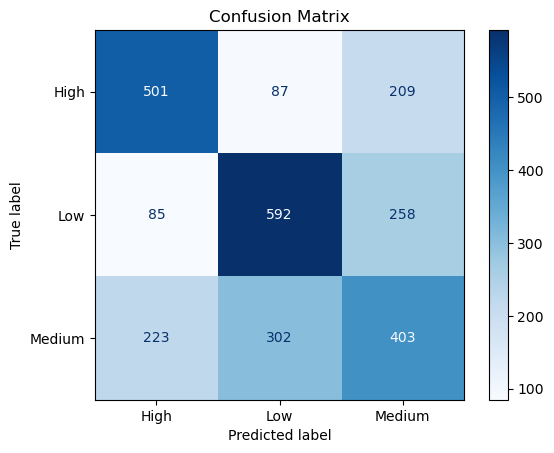

Test data metrics:
Accuracy: 0.5624


In [ ]:
## Rerunning best model (XGBoost) for IMDb score prediction

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Fit Extreme Gradient Boost Classifier
XGB = xgb.XGBClassifier(gamma=0.01, max_depth=7, min_child_weight=5, n_estimators=50, random_state=42, silent=True)
XGB.fit(X_train_std, y1_train)

# Train data classification report
y1_train_pred = XGB.predict(X_train_std)
print("Train data classification report:")
clf_report = pd.DataFrame(classification_report(y1_train, y1_train_pred, output_dict=True))
print(f"CLASSIFICATION REPORT:\n{clf_report}")

# Test data classification report
y1_test_pred = XGB.predict(X_test_std)
print("Test data classification report:")
clf_report = pd.DataFrame(classification_report(y1_test, y1_test_pred, output_dict=True))
print(f"CLASSIFICATION REPORT:\n{clf_report}")

# Test data confusion matrix
cm = confusion_matrix(y1_test, y1_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Low', 'Medium'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

print("Test data metrics:")
print(f"Accuracy: {accuracy_score(y1_test, y1_test_pred):.4}")

Text(0.5, 1.0, 'Relative Feature Importance for XGBoost model')

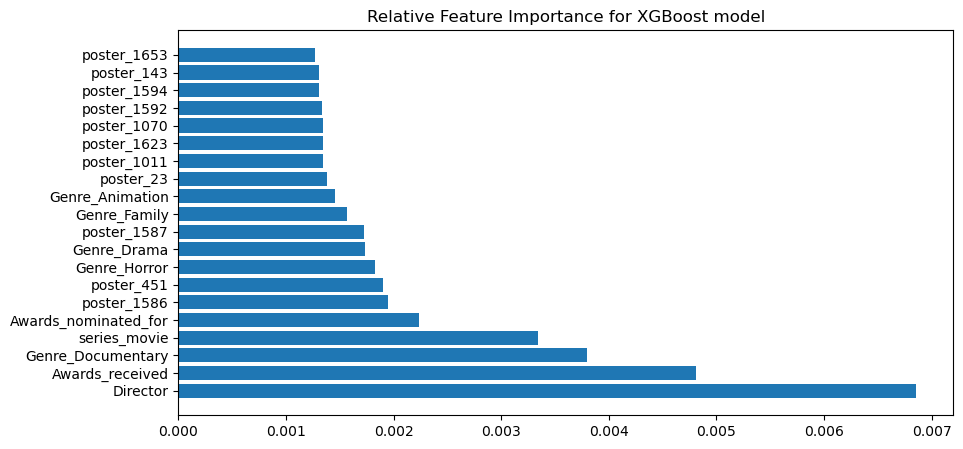

In [ ]:
#Built-in Variable Importance
plt.figure(figsize=(10,5))
num=20

XGB_importances = XGB.feature_importances_
order = np.flip(np.argsort(XGB_importances))[0:num]
plt.barh(range(num),
         XGB_importances[order], 
         tick_label=X_train.columns[order])
plt.title("Relative Feature Importance for XGBoost model")

In [ ]:
## Updating dataset based on XGBoost feature importance

df_updated_scores_features = df_updated_score[['series_movie', 'Awards_nominated_for', 'Awards_received', 'Director','Genre_Family','Genre_Documentary', 'Genre_Horror', 'Genre_Drama', 'Genre_Animation', 'poster_1653','poster_143', 'poster_1594', 'poster_1592', 'poster_1070','poster_1623', 'poster_1011', 'poster_23', 'poster_1587', 'poster_451', 'poster_1586','IMDb_score_target1']]
df_updated_scores_features.head()

,series_movie,Awards_nominated_for,Awards_received,Director,Genre_Family,Genre_Documentary,Genre_Horror,Genre_Drama,Genre_Animation,poster_1653,...,poster_1594,poster_1592,poster_1070,poster_1623,poster_1011,poster_23,poster_1587,poster_451,poster_1586,IMDb_score_target1
0,1,57,74,5933,0,0,1,1,0,0.189667,...,1.303899,0.248649,4.104668,0.007116,0.276259,0.588941,0.000000,0.365025,0.990688,0
1,0,0,1,1049,0,0,0,0,0,0.000000,...,0.997011,0.000000,2.510830,1.983316,0.000000,0.480974,0.346422,0.277813,1.107931,1
2,0,0,0,732,0,0,0,1,0,0.014924,...,0.111423,0.097349,0.749428,0.803122,0.468052,0.019755,2.286677,0.182809,1.330885,1
3,1,0,1,6400,0,0,0,1,0,0.098012,...,1.890380,0.488129,3.175428,2.005553,0.687187,1.539956,0.300540,0.624551,0.060667,2
4,0,4,0,5561,0,0,0,1,1,0.000000,...,0.197588,2.261147,0.279435,1.513178,0.684950,0.176931,0.165512,0.423521,2.333635,2


In [ ]:
## Train-Test Split and Data Scalling
y1_score = df_updated_scores_features.IMDb_score_target1
X_score = df_updated_scores_features.drop('IMDb_score_target1', axis = 1)

X_train_score, X_test_score, y1_train_score, y1_test_score = train_test_split(X_score, y1_score, test_size=0.2, random_state=22)

scaler = StandardScaler()
X_train_std_score = scaler.fit_transform(X_train_score)
X_test_std_score = scaler.transform(X_test_score)
X_std_score = scaler.transform(X_score)

In [ ]:
## Multiple models for IMDb scores prediction
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier


classifiers = {
    "BernoulliNB": BernoulliNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier(),
}


for name, sklearn_classifier in classifiers.items():
    clf = sklearn_classifier
    clf.fit(X_train_std_score, y1_train_score)
    y1_pred_score = clf.predict(X_test_std_score)
    print(y1_pred_score)
    acc = accuracy_score(y1_test_score, y1_pred_score)
    print(name)
    print("Accuracy:", acc)

[1 0 2 ... 1 0 0]
BernoulliNB
Accuracy: 0.5390977443609023
[2 0 2 ... 0 0 2]
KNeighborsClassifier
Accuracy: 0.47406015037593985
[2 0 2 ... 1 0 0]
LogisticRegression
Accuracy: 0.5646616541353383
[2 0 2 ... 1 0 0]
MLPClassifier
Accuracy: 0.5342105263157895
[2 2 1 ... 1 0 0]
DecisionTreeClassifier
Accuracy: 0.4725563909774436
[2 0 1 ... 1 0 0]
RandomForestClassifier
Accuracy: 0.5710526315789474
[2 0 2 ... 1 0 0]
AdaBoostClassifier
Accuracy: 0.5781954887218045
[2 0 1 ... 1 0 0]
XGBClassifier
Accuracy: 0.5616541353383459


In [ ]:
## XGBoost model tunning on IMDb votes prediction

# define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              learning_rate=0.1, 
                              max_depth=5, 
                              n_estimators=50)

# train the XGBoost model
xgb_model.fit(X_train_std_score, y1_train_score)

# evaluate the XGBoost model
y1_pred_xg = xgb_model.predict(X_test_std_score)
accuracy = accuracy_score(y1_test_score, y1_pred_xg)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.53%


In [ ]:
# optimize the XGBoost model
parameters = {'max_depth': [3, 5, 7], 
              'learning_rate': [0.1, 0.01, 0.001], 
              'n_estimators': [10, 20, 50, 100]}
xgb_optimized = GridSearchCV(xgb_model, parameters, cv=3, n_jobs=-1)

xgb_optimized.fit(X_train_std_score, y1_train_score)
print("Optimal Parameters: ", xgb_optimized.best_params_)

# make predictions using the optimized model
y1_pred_optimized = xgb_optimized.predict(X_test_std_score)
accuracy_optimized = accuracy_score(y1_test_score, y1_pred_optimized)
print("Optimized Accuracy: %.2f%%" % (accuracy_optimized * 100.0))

Optimal Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Optimized Accuracy: 58.53%
